### CREATE DATAFRAME

In [1]:
from cloudvolume import CloudVolume
from meshparty import skeletonize, trimesh_io
from caveclient import CAVEclient
import trimesh
import numpy as np
import datetime
import networkx as nx
from scipy.sparse import identity
from scipy.spatial import distance_matrix
import scipy 
from tqdm import tqdm
# import aws
import pandas as pd
import csv
import pyembree
import matplotlib.pyplot as plt
import scipy.spatial as spatial
import itertools

In [2]:

orphans = pd.read_csv("/Users/sheeltanna/Desktop/AGT_REPO/campfire/GT_30_Orphans_Spring_2023 - Sheet1.csv")

In [3]:
def my_array(x):
    res = list(map(str.strip, x.split('; ')))
    return res

In [4]:
orphans['endpoints'] = orphans['endpoints'].map(lambda x: list(map(str.strip, x.split('; '))))

In [5]:
## convert from string list to 2-d array
def convert_to_array(row):
    count = 0
    result = []
    for endpoint in row["endpoints"]:
        # endpoint = tuple(map(int, endpoint.split(', ')))
        endpoint = eval(endpoint)
        # print()
        # print(endpoint)
        # print(type(endpoint))
        if(count == 0):
            result = np.array(endpoint)
            count = count + 1
        else:
            result = np.vstack((result, np.array(endpoint)))
            count = count + 1
            #result = np.concatenate(result, list(tuple))
    #check if there was only 1 point, convert to 2-d array:
    # if(type(result) == list):
        
    if(count == 1 and result.size != 0):
        result = result.reshape(1,3)
    return result 

In [6]:
orphans["real_endpoints"] = orphans.apply(convert_to_array, axis = 1)

In [7]:
orphans["real_endpoints"]

0     [[402547, 228831, 23991], [402958, 229220, 235...
1     [[401602, 224623, 23991], [405273, 226312, 236...
2     [[403332, 227545, 24398], [403566, 227614, 244...
3     [[77262, 113088, 20442], [79178, 109113, 20400...
4     [[100423, 143992, 21653], [100583, 144194, 217...
5      [[71894, 146181, 20442], [71498, 146290, 20403]]
6       [[77575, 107807, 21133], [77000, 99565, 21215]]
7     [[79785, 135709, 21133], [84176, 127514, 21582...
8       [[81198, 106660, 21133], [88834, 99501, 20479]]
9      [[75409, 116393, 21135], [74841, 116076, 21217]]
10    [[351150, 143681, 15176], [348147, 144970, 148...
11    [[344600, 142349, 16939], [344592, 142335, 169...
12    [[366719, 138890, 16417], [367885, 138975, 165...
13    [[353411, 147608, 15177], [352173, 148914, 148...
14    [[346497, 82778, 27090], [339051, 74578, 26769...
15     [[351839, 91058, 27284], [349567, 97065, 26976]]
16    [[357525, 81584, 25828], [358640, 81180, 25734...
17     [[347271, 87374, 25828], [347862, 89018, 

### TIP FINDER FUNCTIONS


In [8]:
def get_and_process_mesh(root_id):
    datastack_name = "minnie65_phase3_v1"
    client = CAVEclient(datastack_name)
    vol = CloudVolume(
        client.info.segmentation_source(),
        use_https=True,
        progress=False,
        bounded=False,
        fill_missing=True,
        secrets={"token": client.auth.token}
    )
    print("Downloading Mesh")
    mesh = vol.mesh.get(str(root_id))[root_id]
    mesh_obj = trimesh.Trimesh(np.divide(mesh.vertices, np.array([1,1,1])), mesh.faces)
    print("Vertices: ", mesh.vertices.shape[0])

    if mesh_obj.volume > 4000000000000:
        print("TOO BIG, SKIPPING")
        #queue_url_endpoints = sqs.get_or_create_queue("root_ids_functional_dlqueue")

        #entries=sqs.construct_rootid_entries([root_id])

        #sqs.send_batch(queue_url_endpoints, entries)

        return None
    trimesh.repair.fix_normals(mesh_obj)
    mesh_obj.fill_holes()

    return mesh_obj

In [9]:
def get_soma(soma_id:str):
    cave_client = CAVEclient('minnie65_phase3_v1')
    soma = cave_client.materialize.query_table(
        "nucleus_neuron_svm",
        filter_equal_dict={'id':soma_id}
    )
    return soma

In [10]:
def process_mesh_ccs(mesh_obj):
    print("Processing CC's")
    ccs_graph = trimesh.graph.connected_components(mesh_obj.edges)
    ccs_len = [len(c) for c in ccs_graph]

    # Subselect the parts of the mesh that are not inside one another 
    # the other components are an artifact of the soma seg and small unfilled sections
    largest_component = ccs_graph[np.argmax(ccs_len)]
    largest_component_remap = np.arange(ccs_graph[np.argmax(ccs_len)].shape[0])
    face_dict = {largest_component[i]:largest_component_remap[i] for i in range(largest_component.shape[0])}

    new_faces_mask = np.isin(mesh_obj.faces, list(face_dict.keys()))
    new_faces_mask = new_faces_mask[:, 0]*new_faces_mask[:, 1]*new_faces_mask[:, 2]

    new_faces = np.vectorize(face_dict.get)(mesh_obj.faces[new_faces_mask])
    new_faces = new_faces[new_faces[:, 0] != None]
    largest_component_mesh = trimesh.Trimesh(mesh_obj.vertices[largest_component], new_faces)

    all_ids = set(largest_component)
    encapsulated_ids = []

    for i in range(1, len(ccs_graph)):
        n_con = largest_component_mesh.contains(mesh_obj.vertices[ccs_graph[i]])
        if np.sum(n_con) / n_con.shape[0] == 0 and n_con.shape[0] > 50:
            all_ids.update(ccs_graph[i])
        else:
            if len(ccs_graph[i]) < 1000:
                encapsulated_ids.append((np.mean(mesh_obj.vertices[ccs_graph[i]], axis=0)/[4,4,40], len(ccs_graph[i])))
            
    all_component = np.array(list(ccs_graph[np.argmax(ccs_len)]))
    all_component_remap = np.arange(all_component.shape[0])
    face_dict = {all_component[i]:all_component_remap[i] for i in range(all_component.shape[0])}
    new_faces_mask = np.isin(mesh_obj.faces, list(face_dict.keys()))
    new_faces_mask = new_faces_mask[:, 0]*new_faces_mask[:, 1]*new_faces_mask[:, 2]

    new_faces = np.vectorize(face_dict.get)(mesh_obj.faces[new_faces_mask])
    new_faces[new_faces[:, 0] != None]
    
    largest_component_mesh = trimesh.Trimesh(mesh_obj.vertices[all_component], new_faces)
    
    mesh_obj = largest_component_mesh
    return mesh_obj, encapsulated_ids, np.max(ccs_len)

In [11]:
def process_defects(mesh_obj, a=.75):
    bad_edges = trimesh.grouping.group_rows(
        mesh_obj.edges_sorted, require_count=1)
    bad_edges_ind = mesh_obj.edges[bad_edges]
    sparse_edges = mesh_obj.edges_sparse
    xs = list(bad_edges_ind[:, 0]) + list(bad_edges_ind[:, 1]) 
    ys = list(bad_edges_ind[:, 1]) + list(bad_edges_ind[:, 0])
    vs = [1]*bad_edges_ind.shape[0]*2
    bad_inds = scipy.sparse.coo_matrix((vs, (xs, ys)), shape=(mesh_obj.vertices.shape[0], mesh_obj.vertices.shape[0]))
    # Make it symmetrical and add identity so each integrates from itself too, then subtract singleton edges
    # I noticed that the number of asymmetrical edges vs the number of single edges I find from group rows
    # Are close but different. Haven't looked into that yet. Also removing edges 1 hop away from single edges to remove bias towards
    # Holes in the mesh that are caused by mesh construction errors as opposed to segmentation errors
    sparse_edges = mesh_obj.edges_sparse + mesh_obj.edges_sparse.T + identity(mesh_obj.edges_sparse.shape[0]) - sparse_edges.multiply(bad_inds) - bad_inds
    degs = mesh_obj.vertex_degree + 1

    # N_iter is a smoothing parameter here. The loop below smooths the vertex error about the mesh to get more consistent connected regions
    n_iter = 2
    angle_sum = np.array(abs(mesh_obj.face_angles_sparse).sum(axis=1)).flatten()
    defs = (2 * np.pi) - angle_sum

    abs_defs = np.abs(defs)
    abs_defs_i = abs_defs.copy()
    for i in range(n_iter):
        abs_defs_i = sparse_edges.dot(abs_defs_i) / degs
    
    verts_select = np.argwhere((abs_defs_i > a))# & (abs_defs < 2.5))

    edges_mask = np.isin(mesh_obj.edges, verts_select)
    edges_mask[bad_edges] = False
    edges_select = edges_mask[:, 0] * edges_mask[:, 1]
    edges_select = mesh_obj.edges[edges_select]

    G = nx.from_edgelist(edges_select)#f_edge_sub)

    ccs = nx.connected_components(G)
    subgraphs = [G.subgraph(cc).copy() for cc in ccs]

    lens = []
    lengths = []
    for i in tqdm(range(len(subgraphs))):
        ns = np.array(list(subgraphs[i].nodes()))
    #     ns = ns[abs_defs[ns ]]
        l = len(ns)
        if l > 20 and l < 5000:
            lens.append(ns)
            lengths.append(l)
    all_nodes = set()
    for l in lens:
        all_nodes.update(l)
    all_nodes = np.array(list(all_nodes))
    # sharp_pts = mesh_obj.vertices[all_nodes]
    centers = np.array([np.mean(mesh_obj.vertices[list(ppts)],axis=0) for ppts in lens])

    return centers, lens


In [12]:
def process_endpoints(mesh_obj, skel_mp):
    # Process the skeleton to get the endpoints
    interior_cc_mask = set()
    el = nx.from_edgelist(skel_mp.edges)
    comps = list(nx.connected_components(el))
    for c in comps:
        if len(c) < 100:
            n_con = mesh_obj.contains(skel_mp.vertices[list(c)])
            if np.sum(n_con) / n_con.shape[0] > .10:
                interior_cc_mask.update(list(c))
    # Process the skeleton to get the endpoints
    edges = skel_mp.edges.copy()

    edge_mask = ~np.isin(edges, interior_cc_mask)
    edge_mask = edge_mask[:, 0] + edge_mask[:, 1]
    edges = edges[edge_mask]
    edges_flat  = edges.flatten()
    edge_bins = np.bincount(edges_flat) 

    eps = np.squeeze(np.argwhere(edge_bins==1))
    eps_nm = skel_mp.vertices[eps]

    eps_comp = distance_matrix(eps_nm, eps_nm)
    eps_comp[eps_comp == 0] = np.inf
    eps_thresh = np.argwhere(~(np.min(eps_comp, axis=0) < 3000))

    eps = np.squeeze(eps[eps_thresh])
    eps_nm = np.squeeze(eps_nm[eps_thresh])
    return eps, eps_nm

In [13]:
def process_mesh_errors(mesh_obj, centers, eps, eps_nm, lens, skel_mp):
    print("Processing mesh errors")
    path_to_root_dict = {}
    for ep in eps:
        path_to_root_dict[ep] = skel_mp.path_to_root(ep)
        
    dists_defects = np.zeros(centers.shape[0])
    sizes = np.zeros(centers.shape[0])
    mesh_map = skel_mp.mesh_to_skel_map
    closest_skel_pts = mesh_map[[l[0] for l in lens]]

    # print(centers, eps_nm)

    dist_matrix = distance_matrix(centers, eps_nm)
    ct = 0

    closest_tip = np.zeros((centers.shape[0]))

    for center in tqdm(centers):
    #     skel_pts_dists = np.linalg.norm(skel_mp.vertices - center, axis=1)
    #     ep_pts_dists = np.linalg.norm(eps_nm - center, axis=1)
        
        closest_skel_pt = closest_skel_pts[ct]
        min_ep = np.inf
        eps_hit = []
        for j, ep in enumerate(eps):
            if closest_skel_pt in path_to_root_dict[ep]:
                eps_hit.append(j)
        if len(eps_hit) == 0:
            dists_defects[ct] = np.inf
            sizes[ct] = np.inf
            ct+=1
            continue
        
        dists = dist_matrix[ct, eps_hit]
    #     print(dists, eps_hit, center / [4,4,40])
        
        amin = np.argmin(dists)
        tip_hit = eps_hit[amin]
        min_dist = dists[amin]
        
        closest_tip[ct] = tip_hit
    #     print(np.argmin(ep_pts_dists), ep_found, eps_nm[np.argmin(ep_pts_dists)]/[4,4,40], eps_nm[j]/[4,4,40], center/[4,4,40])
        dists_defects[ct] = min_dist
        sizes[ct] = len(lens[ct])
        ct+=1
    dists_defects_sub = dists_defects[dists_defects < np.inf]
    sizes_sub = sizes[dists_defects < np.inf]
    centers_sub = centers[dists_defects < np.inf]
    tips_hit_sub = closest_tip[dists_defects < np.inf]
    closest_skel_pts_sub = closest_skel_pts[dists_defects < np.inf]
    inds_sub = np.arange(centers.shape[0])[dists_defects < np.inf]


    # Also ranking each component based on its PCA- if the first component is big enough, the points are mostly linear
    # These point sets seem to be less likely to be true errors
    from sklearn.decomposition import PCA
    pca_vec = np.zeros(inds_sub.shape[0])
    for i in range(inds_sub.shape[0]):
        pca = PCA()#n_components=2)
        pca.fit(mesh_obj.vertices[lens[inds_sub[i]]])

        pca_vec[i] = pca.explained_variance_ratio_[0]

    dists_defects_sub[dists_defects_sub < 4000] = 100
    dists_defects_norm = dists_defects_sub #/ np.max(dists_defects_sub)
    ranks_ep = sizes_sub / dists_defects_norm * (1-pca_vec)
    ranks = sizes_sub**2 * (1-pca_vec)

    #ranks_ep_errors_filt = ranks_ep[ranks_ep > .1]
    centers_ep_send_errors = centers_sub[np.argsort(ranks_ep)][::-1][:20]
    final_mask_eps = np.full(centers_ep_send_errors.shape[0], True)
    tips_hit_send_ep = tips_hit_sub[np.argsort(ranks_ep)][::-1][:20]
    uns, nums = np.unique(tips_hit_send_ep, return_counts=True)

    for un, num in zip(uns, nums):
        if num > 1:
            final_mask_eps[np.argwhere(tips_hit_send_ep == un)[1:]] = False
    centers_errors_ep = centers_ep_send_errors[final_mask_eps]
    centers_errors = centers_sub[np.argsort(ranks)[::-1]][:20]
    return centers_errors, centers_errors_ep, ranks, ranks_ep, path_to_root_dict




In [14]:
def process_mesh_facets(mesh_obj, skel_mp, eps, path_to_root_dict, eps_nm):
    print("Processing facets")
    #can possibly change param here
    locs = np.argwhere(mesh_obj.facets_area > 5000)

    mesh_map = skel_mp.mesh_to_skel_map
    mesh_coords = mesh_obj.vertices[mesh_obj.faces]
    mean_locs = []
    mesh_ind = []
    fs = []
    for l in tqdm(locs):
        fs.append(np.sum(mesh_obj.facets_area[l]))
        fc = mesh_obj.facets[l[0]]
        vert_locs = mesh_coords[fc]
        mean_locs.append(np.mean(vert_locs[:, 0], axis=0))
        mesh_ind.append(fc[0])
    mesh_ind = mesh_obj.faces[mesh_ind][:, 0]
    mean_locs = np.array(mean_locs)
    dists_defects_facets = np.zeros(mean_locs.shape[0])
    mesh_map_facets = skel_mp.mesh_to_skel_map
    closest_skel_pts_facets = mesh_map[[m for m in mesh_ind]]
    dist_matrix_facets = distance_matrix(mean_locs, eps_nm)
    ct = 0

    closest_tip_facets = np.zeros((mean_locs.shape[0]))

    for center in tqdm(mean_locs):

        closest_skel_pt = closest_skel_pts_facets[ct]
        eps_hit = []
        for j, ep in enumerate(eps):
            if closest_skel_pt in path_to_root_dict[ep]:
                eps_hit.append(j)
        if len(eps_hit) == 0:
            dists_defects_facets[ct] = np.inf
            ct+=1
            continue
        
        dists = dist_matrix_facets[ct, eps_hit]
        
        amin = np.argmin(dists)
        tip_hit = eps_hit[amin]
        min_dist = dists[amin]
        
        closest_tip_facets[ct] = tip_hit
        dists_defects_facets[ct] = min_dist
        ct+=1
    dists_defects_sub_facets = dists_defects_facets[dists_defects_facets < np.inf]
    sizes_sub_facets = np.array(fs)[dists_defects_facets < np.inf]
    mean_locs_facets = mean_locs[dists_defects_facets < np.inf]
    tips_hit_sub_facets = closest_tip_facets[dists_defects_facets < np.inf]
    closest_skel_pts_sub_facets = closest_skel_pts_facets[dists_defects_facets < np.inf]
    inds_sub_facets = np.arange(mean_locs.shape[0])[dists_defects_facets < np.inf]
    ranks_ep_facets = sizes_sub_facets**2 / dists_defects_sub_facets
    #ranks_ep_facets_filt = ranks_ep_facets[ranks_ep_facets > 2e7]
    mean_locs_send_facets = mean_locs_facets[np.argsort(ranks_ep_facets)][::-1][:20]
    final_mask_facets = np.full(mean_locs_send_facets.shape[0], True)
    tips_hit_send_facets = tips_hit_sub_facets[np.argsort(ranks_ep_facets)][::-1][:20]
    uns, nums = np.unique(tips_hit_send_facets, return_counts=True)

    for un, num in zip(uns, nums):
        if num > 1:
            final_mask_facets[np.argwhere(tips_hit_send_facets == un)[1:]] = False
    facets_send_final = mean_locs_send_facets[final_mask_facets] / [4,4,40]
    return facets_send_final, ranks_ep_facets

### TIP FINDER FUNCTION

In [15]:

def error_locs_defects(root_id, soma_id = None, soma_table=None, center_collapse=True):
    #print("START", root_id)

    mesh_obj = get_and_process_mesh(root_id)
    if mesh_obj is None:
        return None
    # SKELETONIZE - if we are just looking for general errors, not errors at endpoints, this can be skipped
    try:
        if soma_table==None:
            soma_table = get_soma(str(soma_id))
        if soma_table[soma_table.id == soma_id].shape[0] > 0:
            center = np.array(soma_table[soma_table.id == soma_id].pt_position)[0] * [4,4,40]
        else:
            center=None
    except:
        center = None
    print("Subselecting largest connected component of mesh")
    mesh_obj, encapsulated_ids, max_verts = process_mesh_ccs(mesh_obj)
    

    skel_mp = skeletonize.skeletonize_mesh(trimesh_io.Mesh(mesh_obj.vertices, 
                                            mesh_obj.faces),
                                            invalidation_d=3000,
                                            shape_function='cone',
                                            collapse_function='branch',
#                                             soma_radius = soma_radius,
                                            soma_pt=center,
                                            smooth_neighborhood=5,
                                            cc_vertex_thresh=max_verts - 10
#                                                     collapse_params = {'dynamic_threshold':True}
                                            )
    print("Skel done")

    # find edges that only occur once..  might be faster to find these in the sparse matrix..
    centers, lens = process_defects(mesh_obj)
    eps, eps_nm = process_endpoints(mesh_obj, skel_mp)

    if len(centers) !=0:
        centers_errors, centers_errors_ep, ranks, ranks_ep, path_to_root_dict = process_mesh_errors(mesh_obj, centers, eps, eps_nm, lens, skel_mp)
        ranks_return = np.squeeze(ranks[np.argsort(ranks)[::-1]][:20])
        ranks_ep_return = np.squeeze(ranks_ep[np.argsort(ranks_ep)][::-1][:20])
    else:
        # Assign placeholder values for each of the variables above.
        centers_errors = np.zeros ((1,3))
        centers_errors_ep = np.zeros ((1,3))
        ranks = np.zeros ((1))
        ranks_ep = np.zeros((1, 3))
        path_to_root_dict = {}
        for ep in eps:
            path_to_root_dict[ep] = skel_mp.path_to_root(ep)

        ranks_return = 0
        ranks_ep_return = 0


    #if len(centers_errors.shape) > 1 and centers_errors.shape[0] > 0 and len(centers_errors_ep.shape) > 1 and len(centers_errors_ep.shape[0] > 0):
    #    centers_errors = centers_errors[np.min(distance_matrix(centers_errors, centers_errors_ep), axis=1)>1000]
    facets_send_final, ranks_ep_facets = process_mesh_facets(mesh_obj, skel_mp, eps, path_to_root_dict, eps_nm)

    errors_send = centers_errors / [4,4,40]
    errors_tips_send = centers_errors_ep / [4,4,40]
    encapsulated_centers = [e[0] for e in encapsulated_ids]
    encapsulated_lens = [e[1] for e in encapsulated_ids]
    sorted_encapsulated_send = np.array(encapsulated_centers)[np.argsort(encapsulated_lens)][::-1]



    return sorted_encapsulated_send, facets_send_final, errors_send, errors_tips_send, np.squeeze(ranks_ep_facets[[np.argsort(ranks_ep_facets)][::-1][:20]]), ranks_return, ranks_ep_return



### USING TIP GENERATOR

In [16]:
def find_endpoints(row):
    seg_id = row["seg_id"]
    sorted_encapsulated_send, facets_send_final, errors_send, errors_tips_send, dummy, dummy2, dummy3 = error_locs_defects(seg_id)
    #facets_send_final = facets_send_final[facets_send_final != [0,0,0]]
    #errors_tips_send = errors_tips_send[errors_tips_send != [0,0,0]]
    together = np.vstack((facets_send_final, errors_tips_send))
    #should alter "together" if not set together equal to this line
    # print(together)
    # new = together[together != [0,0,0]]
    mask=np.sum(together,axis=1)
    together = together[mask > 0]
    return together

In [17]:
def generate_endpoints(dataframe) :
    dataframe["endpoints_generated"] = dataframe.apply(find_endpoints, axis = 1)
    return dataframe

### ACCURACY FUNCTION

In [18]:
def pred_eps_acc(gt_endpoints, pred_endpoints, threshold):
    # Calculate distances
    dist_matrix = np.array(spatial.distance.cdist(gt_endpoints, pred_endpoints, metric = 'euclidean'))

    # Apply threshold
    dist_matrix[dist_matrix > threshold] = 0

    # Calculating accuracy
    valid_eps = np.count_nonzero(dist_matrix, axis = 1)
    accuracy = np.count_nonzero(valid_eps) / len(gt_endpoints)

    #If more than one valid endpoint found for a single ground truth endpoint, add the other valid endpoints to extra_valid_pairs
    # extra_valid_pairs = []
    # [[extra_valid_pairs.append([gt_endpoints[i], pred_endpoints[index]]) \
    #     for index, j in enumerate(dist_matrix[i]) if j != np.min(dist_matrix[i][dist_matrix[i] != 0]) if j != 0] \
    #         for i in valid_eps if i > 1]

    # return accuracy, extra_valid_pairs
    return accuracy

### TESTING

In [19]:
## TESTING ON THE 30 NEWLY LABELLED ORPHANS

orphans = generate_endpoints(orphans)


Vertices:  7993
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7992/7992 [00:00<00:00, 1246407.29it/s]


Skel done


100%|██████████| 26/26 [00:00<00:00, 169862.78it/s]


Processing facets


100%|██████████| 537/537 [00:00<00:00, 73521.83it/s]


Vertices:  21335
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 21334/21334 [00:00<00:00, 1065900.51it/s]


Skel done


100%|██████████| 87/87 [00:00<00:00, 278765.81it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 5866.16it/s]


Processing facets


100%|██████████| 1606/1606 [00:00<00:00, 49383.46it/s]


Vertices:  1451
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1450/1450 [00:00<00:00, 398776.53it/s]


Skel done


100%|██████████| 6/6 [00:00<00:00, 68947.46it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 32017.59it/s]


Processing facets


100%|██████████| 97/97 [00:00<00:00, 707560.85it/s]


Vertices:  6056
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 6049/6049 [00:00<00:00, 1189969.74it/s]


Skel done


100%|██████████| 51/51 [00:00<00:00, 226599.05it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 25850.87it/s]


Processing facets


100%|██████████| 465/465 [00:00<00:00, 63523.15it/s]


Vertices:  1180
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1179/1179 [00:00<00:00, 476359.16it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 84072.91it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 13357.66it/s]


Processing facets


100%|██████████| 98/98 [00:00<00:00, 54291.61it/s]


Vertices:  677
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 676/676 [00:00<00:00, 219403.35it/s]


Skel done


100%|██████████| 4/4 [00:00<00:00, 50081.24it/s]


Processing facets


100%|██████████| 52/52 [00:00<00:00, 592673.39it/s]


Vertices:  14714
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 14505/14505 [00:00<00:00, 586727.68it/s]


Skel done


100%|██████████| 91/91 [00:00<00:00, 255476.35it/s]


Processing mesh errors


100%|██████████| 9/9 [00:00<00:00, 15388.80it/s]


Processing facets


100%|██████████| 1059/1059 [00:00<00:00, 28891.61it/s]


Vertices:  24966
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 24965/24965 [00:00<00:00, 462699.73it/s]


Skel done


100%|██████████| 158/158 [00:00<00:00, 297575.23it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 10891.72it/s]


Processing facets


100%|██████████| 1792/1792 [00:00<00:00, 25210.62it/s]


Vertices:  23312
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 23105/23105 [00:00<00:00, 668294.56it/s]


Skel done


100%|██████████| 168/168 [00:00<00:00, 293601.28it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 14602.56it/s]


Processing facets


100%|██████████| 1599/1599 [00:00<00:00, 40407.36it/s]


Vertices:  2490
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2489/2489 [00:00<00:00, 542966.80it/s]


Skel done


100%|██████████| 21/21 [00:00<00:00, 151081.28it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 5479.17it/s]


Processing facets


100%|██████████| 153/153 [00:00<00:00, 61889.14it/s]


Vertices:  7233
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7232/7232 [00:00<00:00, 415079.87it/s]


Skel done


100%|██████████| 50/50 [00:00<00:00, 228199.35it/s]


Processing facets


100%|██████████| 452/452 [00:00<00:00, 44576.19it/s]


Vertices:  80
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 79/79 [00:00<00:00, 60598.03it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 12671.61it/s]


Processing facets


100%|██████████| 6/6 [00:00<00:00, 136770.78it/s]


Vertices:  2238
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2237/2237 [00:00<00:00, 527115.62it/s]


Skel done


100%|██████████| 8/8 [00:00<00:00, 39383.14it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 2474.52it/s]


Processing facets


100%|██████████| 157/157 [00:00<00:00, 53058.23it/s]


Vertices:  7187
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7186/7186 [00:00<00:00, 728641.81it/s]


Skel done


100%|██████████| 39/39 [00:00<00:00, 216659.41it/s]


Processing facets


100%|██████████| 486/486 [00:00<00:00, 41211.24it/s]


Vertices:  44825
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 44696/44696 [00:00<00:00, 406771.13it/s]


Skel done


100%|██████████| 250/250 [00:00<00:00, 258716.01it/s]


Processing mesh errors


100%|██████████| 23/23 [00:00<00:00, 9418.96it/s]


Processing facets


100%|██████████| 3428/3428 [00:00<00:00, 26570.56it/s]


Vertices:  11531
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11530/11530 [00:00<00:00, 1090645.79it/s]


Skel done


100%|██████████| 77/77 [00:00<00:00, 245411.40it/s]


Processing mesh errors


100%|██████████| 6/6 [00:00<00:00, 29399.33it/s]


Processing facets


100%|██████████| 825/825 [00:00<00:00, 63899.78it/s]


Vertices:  3820
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3801/3801 [00:00<00:00, 791507.77it/s]


Skel done


100%|██████████| 28/28 [00:00<00:00, 127930.84it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 8232.20it/s]


Processing facets


100%|██████████| 253/253 [00:00<00:00, 53450.81it/s]


Vertices:  24046
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 24033/24033 [00:00<00:00, 382637.76it/s]


Skel done


100%|██████████| 172/172 [00:00<00:00, 327620.48it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 18966.49it/s]


Processing facets


100%|██████████| 1633/1633 [00:00<00:00, 22864.83it/s]


Vertices:  3065
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3060/3060 [00:00<00:00, 808375.02it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 84260.57it/s]


Processing facets


100%|██████████| 230/230 [00:00<00:00, 60353.47it/s]


Vertices:  5754
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5753/5753 [00:00<00:00, 1207759.69it/s]


Skel done


100%|██████████| 18/18 [00:00<00:00, 110376.42it/s]


Processing facets


100%|██████████| 415/415 [00:00<00:00, 71229.54it/s]


Vertices:  10302
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 10202/10202 [00:00<00:00, 474004.58it/s]


Skel done


100%|██████████| 75/75 [00:00<00:00, 170039.35it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 17980.26it/s]


Processing facets


100%|██████████| 742/742 [00:00<00:00, 49908.97it/s]


Vertices:  5808
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5807/5807 [00:00<00:00, 558157.60it/s]


Skel done


100%|██████████| 38/38 [00:00<00:00, 34483.68it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 24487.18it/s]


Processing facets


100%|██████████| 457/457 [00:00<00:00, 39498.78it/s]


Vertices:  12089
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11967/11967 [00:00<00:00, 1210642.45it/s]


Skel done


100%|██████████| 54/54 [00:00<00:00, 207600.75it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 25970.92it/s]


Processing facets


100%|██████████| 991/991 [00:00<00:00, 68020.93it/s]


Vertices:  15375
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 15204/15204 [00:00<00:00, 683840.71it/s]


Skel done


100%|██████████| 68/68 [00:00<00:00, 271890.06it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 15279.80it/s]


Processing facets


100%|██████████| 1116/1116 [00:00<00:00, 63264.90it/s]


Vertices:  27011
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 27009/27009 [00:00<00:00, 506224.61it/s]


Skel done


100%|██████████| 154/154 [00:00<00:00, 164023.06it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 3384.74it/s]


Processing facets


100%|██████████| 1856/1856 [00:00<00:00, 14377.13it/s]


Vertices:  2424
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2423/2423 [00:00<00:00, 392068.15it/s]


Skel done


100%|██████████| 18/18 [00:00<00:00, 109734.70it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 4806.31it/s]


Processing facets


100%|██████████| 183/183 [00:00<00:00, 39712.21it/s]


Vertices:  2722
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2721/2721 [00:00<00:00, 865713.51it/s]


Skel done


100%|██████████| 21/21 [00:00<00:00, 40552.66it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 2870.84it/s]


Processing facets


100%|██████████| 183/183 [00:00<00:00, 6639.37it/s]


Vertices:  3523
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3522/3522 [00:00<00:00, 151236.61it/s]


Skel done


100%|██████████| 29/29 [00:00<00:00, 94731.17it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 13888.42it/s]


Processing facets


100%|██████████| 234/234 [00:00<00:00, 41184.47it/s]


Vertices:  172
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 171/171 [00:00<00:00, 101546.93it/s]


Skel done


100%|██████████| 3/3 [00:00<00:00, 24197.91it/s]


Processing facets


100%|██████████| 14/14 [00:00<00:00, 312341.79it/s]


Vertices:  22862
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 22838/22838 [00:00<00:00, 202032.60it/s]


Skel done


100%|██████████| 171/171 [00:00<00:00, 268926.13it/s]


Processing mesh errors


100%|██████████| 14/14 [00:00<00:00, 9768.80it/s]


Processing facets


100%|██████████| 1585/1585 [00:00<00:00, 23436.41it/s]


In [36]:
#apply function to entire df 
count = 0
acc_array = []
for index, row in orphans.iterrows():
    if (type(row["real_endpoints"])== list and type(row["endpoints_generated"]) == list):
        acc = 1
        print("both empty")
    elif(type(row["endpoints_generated"]) == list and type(row["real_endpoints"]) != list):
        acc = 0
        print("no endpoints generated, but endpoints exist")
    else:
        count = count + 1
        # print("predicted,", row["endpoints_generated"])
        # print()
        # print("real,", row["real_endpoints"])
        # print()
        # print("seg_id", row["seg_id"])
        # print()
        # print(type(row["real_endpoints"]))

        #print(str(count) + ':')
        acc = pred_eps_acc(row["real_endpoints"], row["endpoints_generated"], 200)
        acc_array.append(acc)
        if(acc == 1):
            print(row["seg_id"])
        #print(acc)
        # print("NEXT")

864691135909994000
864691134406233920
864691134865499607
864691136235124174
864691135258412858
864691134996628976


In [37]:
acc_array = np.array(acc_array)
print(acc_array)
print()
print(len(acc_array[acc_array == 1.0]))


###SEVENTY PERCENT OF ORPHANS HAD SOME ENDPOINT FOUND


# print(len(acc_array))
# print(acc_array)
# print(acc_array[])

[1.         0.33333333 0.         0.66666667 1.         0.
 0.5        0.66666667 0.5        0.5        0.5        0.
 1.         0.         0.75       0.5        0.66666667 0.5
 0.5        1.         0.         0.5        0.         0.66666667
 1.         0.5        0.66666667 1.         0.         0.66666667]

6


In [ ]:
###all perfect scores


--Possiby search the 6 perfect ones dependent on task 
--changing invalidation_d resulted in the biggest change in accuracies 
--eps_nm? 


### FINE TUNING

In [22]:

# indices 2, 5 11

print(orphans["seg_id"][2])
print(orphans["endpoints_generated"][2])

864691135552841025
[]


NOTES FOR SMALL PROCESSES: 

1. index 2 was very small process with two clear flat ends. Skeleton did not reach one flat end and resulted in zero eps_nm and 1 error location which was rightfully filtered out. Changing threshold for eps_nm (not sure if we shoudl do this) found 2 endpoints, but these locations are not correct. They represent the ends of the skeleton. Increasing inval_d did not find the correct endpoints (as exepcted). Decreasing invalidation_d from 5000 to 1500 found one of the flat regions, but endpoint filtered out before getting facets. Endpoint not found if eps_nm threshold returned to 3000. 

2. index 5 also somewhat small, but has 2 flat ends. Skeleton did reach both ends (somewhat), but resulted in zero eps_nm with threshold of 3000. Changed eps_nm threshold to 1500 (not sure if we should do this) and found 2 endpoints (ends of the skeleton). Left invalidation_d quite low at 1500. AFter filtering and scaling, the two endpoints in ep_nm were gone. We should focus on translation from eps_nm to facets. 

3. Index 11 was VERY VERY small and flat. Resonable that skeleton wasn't albe to be processed. 

In [38]:
mesh_obj = get_and_process_mesh(864691135909994000)
print("Processing CC's")
ccs_graph = trimesh.graph.connected_components(mesh_obj.edges)
ccs_len = [len(c) for c in ccs_graph]

# Subselect the parts of the mesh that are not inside one another 
# the other components are an artifact of the soma seg and small unfilled sections
largest_component = ccs_graph[np.argmax(ccs_len)]
largest_component_remap = np.arange(ccs_graph[np.argmax(ccs_len)].shape[0])
face_dict = {largest_component[i]:largest_component_remap[i] for i in range(largest_component.shape[0])}

new_faces_mask = np.isin(mesh_obj.faces, list(face_dict.keys()))
new_faces_mask = new_faces_mask[:, 0]*new_faces_mask[:, 1]*new_faces_mask[:, 2]

new_faces = np.vectorize(face_dict.get)(mesh_obj.faces[new_faces_mask])
new_faces = new_faces[new_faces[:, 0] != None]
largest_component_mesh = trimesh.Trimesh(mesh_obj.vertices[largest_component], new_faces)

all_ids = set(largest_component)
encapsulated_ids = []

for i in range(1, len(ccs_graph)):
    n_con = largest_component_mesh.contains(mesh_obj.vertices[ccs_graph[i]])
    if np.sum(n_con) / n_con.shape[0] == 0 and n_con.shape[0] > 50:
        all_ids.update(ccs_graph[i])
    else:
        if len(ccs_graph[i]) < 1000:
            encapsulated_ids.append((np.mean(mesh_obj.vertices[ccs_graph[i]], axis=0)/[4,4,40], len(ccs_graph[i])))
        
all_component = np.array(list(ccs_graph[np.argmax(ccs_len)]))
all_component_remap = np.arange(all_component.shape[0])
face_dict = {all_component[i]:all_component_remap[i] for i in range(all_component.shape[0])}
new_faces_mask = np.isin(mesh_obj.faces, list(face_dict.keys()))
new_faces_mask = new_faces_mask[:, 0]*new_faces_mask[:, 1]*new_faces_mask[:, 2]

new_faces = np.vectorize(face_dict.get)(mesh_obj.faces[new_faces_mask])
new_faces[new_faces[:, 0] != None]

largest_component_mesh = trimesh.Trimesh(mesh_obj.vertices[all_component], new_faces)

mesh_obj = largest_component_mesh

Vertices:  7993
Processing CC's


In [39]:
skel_mp = skeletonize.skeletonize_mesh(trimesh_io.Mesh(mesh_obj.vertices, 
                                            mesh_obj.faces),
                                            invalidation_d=3000,
                                            shape_function='cone',
                                            collapse_function='branch',
                                            #soma_radius = soma_radius,
                                            #soma_pt=center,
                                            smooth_neighborhood=5,
                                            #cc_vertex_thresh=max_verts - 10
                                            #collapse_params = {'dynamic_threshold':True}
)

100%|██████████| 7992/7992 [00:00<00:00, 1123127.98it/s]


In [40]:
from meshparty import trimesh_io, trimesh_vtk, skeletonize, mesh_filters
skel_actor = trimesh_vtk.skeleton_actor(skel_mp,
                   edge_property=None,
                   vertex_property=None,
                   vertex_data=None,
                   normalize_property=True,
                   color=(1, 0, 1),
                   line_width=5,
                   opacity=0.7,
                   lut_map=None)

In [26]:
a = 0.75
bad_edges = trimesh.grouping.group_rows(
mesh_obj.edges_sorted, require_count=1)
bad_edges_ind = mesh_obj.edges[bad_edges]
sparse_edges = mesh_obj.edges_sparse
xs = list(bad_edges_ind[:, 0]) + list(bad_edges_ind[:, 1]) 
ys = list(bad_edges_ind[:, 1]) + list(bad_edges_ind[:, 0])
vs = [1]*bad_edges_ind.shape[0]*2
bad_inds = scipy.sparse.coo_matrix((vs, (xs, ys)), shape=(mesh_obj.vertices.shape[0], mesh_obj.vertices.shape[0]))
# Make it symmetrical and add identity so each integrates from itself too, then subtract singleton edges
# I noticed that the number of asymmetrical edges vs the number of single edges I find from group rows
# Are close but different. Haven't looked into that yet. Also removing edges 1 hop away from single edges to remove bias towards
# Holes in the mesh that are caused by mesh construction errors as opposed to segmentation errors
sparse_edges = mesh_obj.edges_sparse + mesh_obj.edges_sparse.T + identity(mesh_obj.edges_sparse.shape[0]) - sparse_edges.multiply(bad_inds) - bad_inds
degs = mesh_obj.vertex_degree + 1

# N_iter is a smoothing parameter here. The loop below smooths the vertex error about the mesh to get more consistent connected regions
n_iter = 2
angle_sum = np.array(abs(mesh_obj.face_angles_sparse).sum(axis=1)).flatten()
defs = (2 * np.pi) - angle_sum

abs_defs = np.abs(defs)
abs_defs_i = abs_defs.copy()
for i in range(n_iter):
    abs_defs_i = sparse_edges.dot(abs_defs_i) / degs

verts_select = np.argwhere((abs_defs_i > a))# & (abs_defs < 2.5))

edges_mask = np.isin(mesh_obj.edges, verts_select)
edges_mask[bad_edges] = False
edges_select = edges_mask[:, 0] * edges_mask[:, 1]
edges_select = mesh_obj.edges[edges_select]

G = nx.from_edgelist(edges_select)#f_edge_sub)

ccs = nx.connected_components(G)
subgraphs = [G.subgraph(cc).copy() for cc in ccs]

lens = []
lengths = []
for i in tqdm(range(len(subgraphs))):
    ns = np.array(list(subgraphs[i].nodes()))
#     ns = ns[abs_defs[ns ]]
    l = len(ns)
    if l > 20 and l < 5000:
        lens.append(ns)
        lengths.append(l)
all_nodes = set()
for l in lens:
    all_nodes.update(l)
all_nodes = np.array(list(all_nodes))
# sharp_pts = mesh_obj.vertices[all_nodes]
centers = np.array([np.mean(mesh_obj.vertices[list(ppts)],axis=0) for ppts in lens])

100%|██████████| 6/6 [00:00<00:00, 46863.73it/s]


In [41]:
interior_cc_mask = set()
el = nx.from_edgelist(skel_mp.edges)
comps = list(nx.connected_components(el))
for c in comps:
    if len(c) < 100:
        n_con = mesh_obj.contains(skel_mp.vertices[list(c)])
        if np.sum(n_con) / n_con.shape[0] > .10:
            interior_cc_mask.update(list(c))
# Process the skeleton to get the endpoints
edges = skel_mp.edges.copy()

edge_mask = ~np.isin(edges, interior_cc_mask)
edge_mask = edge_mask[:, 0] + edge_mask[:, 1]
edges = edges[edge_mask]
edges_flat  = edges.flatten()
edge_bins = np.bincount(edges_flat) 

eps = np.squeeze(np.argwhere(edge_bins==1))
eps_nm = skel_mp.vertices[eps]
print(eps_nm)

eps_comp = distance_matrix(eps_nm, eps_nm)
eps_comp[eps_comp == 0] = np.inf
eps_thresh = np.argwhere(~(np.min(eps_comp, axis=0) < 1500))

eps = np.squeeze(eps[eps_thresh])
eps_nm = np.squeeze(eps_nm[eps_thresh])
print()
print(eps_nm)

[[1610343.  914844.  959658.]
 [1611897.  916776.  942102.]]

[[1610343.  914844.  959658.]
 [1611897.  916776.  942102.]]


### VISUALIZING

In [42]:
#VISUALZING HERE
syn_actor = trimesh_vtk.point_cloud_actor(eps_nm, size=100, color=(0.0, 0.0, 0.9))
syn_actor2 = trimesh_vtk.point_cloud_actor(centers, size=100, color=(0.9, 0.2, 0.9))
mesh_actor = trimesh_vtk.mesh_actor(mesh_obj, opacity=1, color=(0.7, 0.7, 0.7))
trimesh_vtk.render_actors([mesh_actor, skel_actor, syn_actor2, syn_actor])

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x7f7f420caa00) at 0x7f7f48f35f40>

### BAD AND GOOD PROCESS 


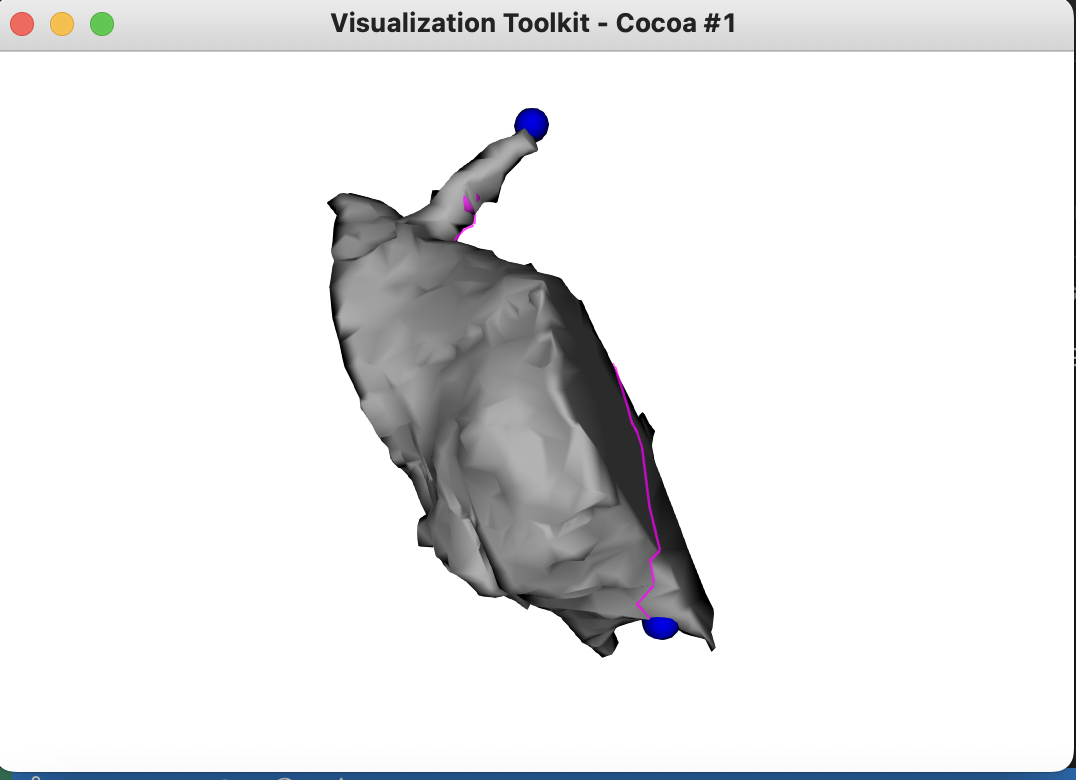

In [30]:
from IPython.display import Image
###PROCESS THAT it DOESN'T DO WELL ON
Image('/Users/sheeltanna/Desktop/AGT_REPO/campfire/Small_Orphan_Image.png')

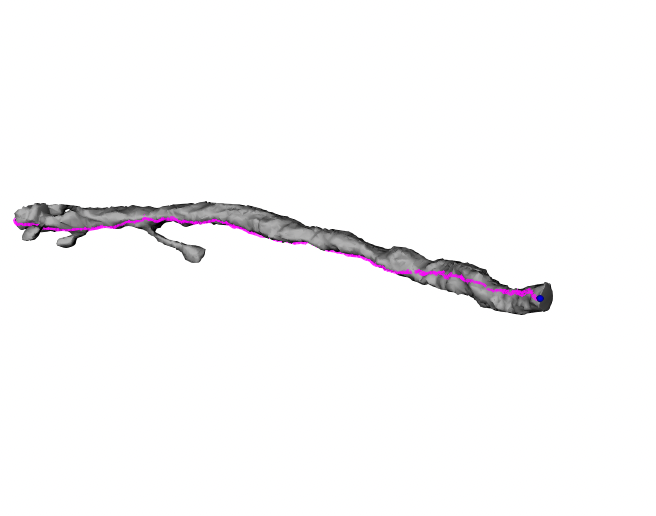

In [43]:
from IPython.display import Image
###PROCESS THAT it DOESN'T DO WELL ON
Image('/Users/sheeltanna/Desktop/AGT_REPO/campfire/Screen Shot 2023-04-05 at 11.10.49 PM.png')

In [31]:
#Getting the predicted endpoints 
sorted_encapsulated_send, facets_send_final, errors_send, errors_tips_send, dummy, dummy2, dummy3 = error_locs_defects(864691134330810585)

Vertices:  677
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 676/676 [00:00<00:00, 397720.51it/s]


Skel done


100%|██████████| 4/4 [00:00<00:00, 33893.37it/s]


Processing facets


100%|██████████| 52/52 [00:00<00:00, 626735.08it/s]


In [ ]:
#getting the accuracy + seeing the predicted vs real endpoints
together = np.vstack((facets_send_final, errors_tips_send))
    #should alter "together" if not set together equal to this line
    # print(together)
    # new = together[together != [0,0,0]]
mask=np.sum(together,axis=1)
together = together[mask > 0]
print("predicted")
print(together)
print()
print("real")
print(orphans["real_endpoints"][1])
print()
print("accurcy")
acc = pred_eps_acc(orphans["real_endpoints"][1], together, 200)
print(acc)


predicted
[]

real
[[401602 224623  23991]
 [405273 226312  23618]
 [409204 219553  23892]]

accurcy
0.0


In [ ]:
print("before scaling of endpoints")
print(eps_nm)
print()
print("after scaling of endpoints")
print(facets_send_final)
print()
print("before scaling of errors")
print(centers)
print()
print("after scaling of errors")
print(errors_tips_send)

before scaling of endpoints
[[285558. 585291. 816102.]
 [287784. 584598. 817698.]]

after scaling of endpoints
[]

before scaling of errors
[]

after scaling of errors
[[0. 0. 0.]]
